In [22]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from gerrychain import Graph, GeographicPartition, Election, MarkovChain, tree, constraints
from functools import partial
from gerrychain.updaters import Tally, cut_edges
from gerrychain.metrics import polsby_popper
from gerrychain.proposals import recom
import os
from gerrychain.accept import always_accept

from candidate import Candidate

In [23]:
PROCESSED_SHAPEFILE_PATH = os.path.join(os.getcwd())
VA_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "virginia", "VA_precincts.shp")
EXPORT_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "virginia")

ITERATIONS = 5000
SAFE_SEAT_THRESHOLD = 0.66
MINORITY_POP_THRESHOLD = RACE_WINNER_THRESHOLD = 0.5
TOTAL_DISTRICTS = 10
FIVE_FIVE = 2
THREE_THREE_FOUR = 3.35


In [24]:
va_graph = Graph.from_file(VA_PATH, ignore_errors=True)

In [25]:
total_population = sum(va_graph.nodes[node]["TOTPOP"] for node in va_graph.nodes)

candidate_D1 = Candidate("Democrat1", "Democratic")
candidate_D2 = Candidate("Democrat2", "Democratic")
candidate_D3 = Candidate("Democrat3", "Democratic")
candidate_D4 = Candidate("Democrat4", "Democratic")
candidate_D5 = Candidate("Democrat5", "Democratic")
candidate_R1 = Candidate("Republican1", "Republican")
candidate_R2 = Candidate("Republican2", "Republican")
candidate_R3 = Candidate("Republican3", "Republican")
candidate_R4 = Candidate("Republican4", "Republican")
candidate_R5 = Candidate("Republican5", "Republican")

In [26]:
for node in va_graph.nodes:
    # Convert all votes to numbers to avoid NaNs 
    va_graph.nodes[node]["G18DHOR"] = float(va_graph.nodes[node]["G18DHOR"])
    va_graph.nodes[node]["G18RHOR"] = float(va_graph.nodes[node]["G18DSEN"])
    if not va_graph.nodes[node]["G18DHOR"]:
        print(node)
    if not va_graph.nodes[node]["G18RHOR"]:
        print(node)


In [27]:
partition_55 = tree.recursive_tree_part(va_graph, [1, 2], total_population / FIVE_FIVE, "TOTPOP", 0.01, 1)
partition_334 = tree.recursive_tree_part(va_graph, [1, 2, 3], total_population / THREE_THREE_FOUR, "TOTPOP", 0.01, 1)

va_election = Election("CongressionalRace" , {"Democratic": "G18DHOR", "Republican": "G18RHOR"})

In [28]:
# Create a new partition with the election results
new_partition55 = GeographicPartition(va_graph, assignment=partition_55, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": va_election
    })
new_partition334 = GeographicPartition(va_graph, assignment=partition_334, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": va_election
    })

In [29]:
ideal_pop55 = total_population / FIVE_FIVE
proposal55 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop55, epsilon=.01, node_repeats=2)
compactness55 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition55["cut_edges"])
)
pop_constraint55 = constraints.within_percent_of_ideal_population(new_partition55, 0.3)

ideal_pop334 = total_population / THREE_THREE_FOUR
proposal334 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop334, epsilon=.01, node_repeats=2)
compactness334 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition334["cut_edges"])
)
pop_constraint334 = constraints.within_percent_of_ideal_population(new_partition334, 0.4)


In [30]:
chain55 = MarkovChain(
    proposal=proposal55,
    constraints=[
        compactness55,
        pop_constraint55
    ],
    accept=always_accept,
    initial_state=new_partition55,
    total_steps=ITERATIONS
)

chain334 = MarkovChain(
    proposal=proposal334,
    constraints=[
        compactness334,
        pop_constraint334
    ],
    accept=always_accept,
    initial_state=new_partition334,
    total_steps=ITERATIONS
)


In [31]:
import warnings
warnings.filterwarnings('ignore')

polsby_popper_scores = pd.DataFrame()
dem_splits = pd.DataFrame()
rep_splits = pd.DataFrame()
black_pop = pd.DataFrame()
asian_pop = pd.DataFrame()
hisp_pop = pd.DataFrame()
white_pop = pd.DataFrame()
total_pop = pd.DataFrame()
equal_pop = pd.DataFrame()

all_data = {}
opportunity_reps_count = pd.DataFrame()


unique_plans = {}
OPPORTUNITY_REP_COUNT = int(TOTAL_DISTRICTS * 0.25)

master_dict = {"chain55": chain55, "chain334": chain334}
dem_candidates = [candidate_D1, candidate_D2, candidate_D3, candidate_D4, candidate_D5]
rep_candidates = [candidate_R1, candidate_R2, candidate_R3, candidate_R4, candidate_R5]

chain_dict = {}
for link in master_dict:
    all_elections = []

    lst_opp_reps = []
    opportunity_reps = pd.DataFrame()
    district_series = {}
    # Print the number of districts in each plan
    num_districts = 0
    for step in master_dict[link]:
        num_districts = len(step["population"])
        break
    for district in range(1, num_districts+1):
        district_series[str(district)] = pd.Series()
    for step in master_dict[link]:
        blk = pd.Series(step["black"])
        asn = pd.Series(step["asian"])
        hsp = pd.Series(step["hisp"])
        wt = pd.Series(step["white"])
        tot = pd.Series(step["population"])
        eq_pop = pd.Series(max(step["population"].values()) - min(step["population"].values()))
        polsby_popper_scores = polsby_popper_scores.append(pd.Series(polsby_popper(step)), ignore_index=True)
        black_pop = black_pop.append(blk, ignore_index=True)
        asian_pop = asian_pop.append(asn, ignore_index=True)
        hisp_pop = hisp_pop.append(hsp, ignore_index=True)
        white_pop = white_pop.append(wt, ignore_index=True)
        total_pop = total_pop.append(tot, ignore_index=True)
        
        
        equal_pop = equal_pop.append(eq_pop.values[0] / tot, ignore_index=True)       
        dem_splits = dem_splits.append(pd.Series(step["CongressionalRace"].percents("Democratic")), ignore_index=True)
        rep_splits = rep_splits.append(pd.Series(step["CongressionalRace"].percents("Republican")), ignore_index=True)


        minority_pop = blk + asn + hsp
        minority_pop_percentage = minority_pop / tot
        minorit_pop_threshold = minority_pop_percentage /  TOTAL_DISTRICTS
        opp_reps = pd.Series(minority_pop_percentage[minority_pop_percentage > minorit_pop_threshold].count())
        opportunity_reps_count = opportunity_reps_count.append(opp_reps, ignore_index=True)

        election = {}
        sum_of_ops = 0

        for district, pop in step["population"].items():
            min_pop = (step["black"][district] + step["asian"][district] + step["hisp"][district]) / step["population"][district]
            op_rep = min_pop * len(step["population"])
            sum_of_ops += op_rep
            minority_pop_dist = step["black"][district] + step["asian"][district] + step["hisp"][district]
            value = round((len(step["population"]) * min_pop))
            # print(link, minority_pop_dist, 100 / len(step["population"]) *  0.01 * pop)
            if str(district) in district_series:
                district_series[str(district)] = district_series[str(district)].append(pd.Series(value), ignore_index=True)
                

            dem = pd.Series(step["CongressionalRace"].percents("Democratic")[district-1])
            rep = pd.Series(step["CongressionalRace"].percents("Republican")[district-1])
            dem_seat_share_percentage = dem[dem > 0.5].count() / TOTAL_DISTRICTS
            dem_vote_share_percentage = dem.mean()


            top_candidates = {} # Key = name of candidate, Value = number of votes
            for cand in dem_candidates:
                top_candidates[cand.get_name()] = 0
            for cand in rep_candidates:
                top_candidates[cand.get_name()] = 0
            total_reps = round((step["population"][district] / total_population) * TOTAL_DISTRICTS)
            dem_votes = step["CongressionalRace"].votes("Democratic")[district-1]
            rep_votes = step["CongressionalRace"].votes("Republican")[district-1]
            weight = 1
            for cand in range(total_reps):
                top_candidates[rep_candidates[cand].get_name()] += (weight * rep_votes)
                top_candidates[dem_candidates[cand].get_name()] += (weight * dem_votes)
                weight -= .15
            election[district] = top_candidates
            
            for part in election:
                election[part] = dict(sorted(election[part].items(), key=lambda item: item[1], reverse=True))

            if dem.max() > 0.6:
                unique_plans["High Democrat Concentration In District - "+link] = [step, election]
                
            if rep.max() > 0.6:
                unique_plans["High Republican Concentration In District - "+link] = [step, election]
            min_threshold = (100 / len(step["population"]) * 0.01 * pop)
            if minority_pop_percentage[minority_pop_percentage > min_threshold].count().sum() >= OPPORTUNITY_REP_COUNT:
                unique_plans["High Opportunity Representative Count"+link] = [step, election]
                
            if abs(dem_seat_share_percentage - dem_vote_share_percentage) > 0.15:
                unique_plans["Large Difference Between Democrat Vote Share and Seat Share - "+link] = [step, election]
                
            if abs((1-dem_seat_share_percentage) - (1-dem_vote_share_percentage)) > 0.15:
                unique_plans["Large Difference Between Republican Vote Share and Seat Share - "+link] = [step, election]
        all_elections.append(election)
        lst_opp_reps.append(sum_of_ops)
        opportunity_reps = pd.DataFrame(list(district_series.values()), index=list(district_series.keys()))

    chain_dict[master_dict[link]] = all_elections
    minority_pop = black_pop + asian_pop + hisp_pop
    dem_seat_share = dem_splits[dem_splits > RACE_WINNER_THRESHOLD].count(axis=1)
    dem_seat_share_percentage =  dem_seat_share / len(step["population"])
    dem_vote_share_percentage = dem_splits.mean(axis=1).mean()
    rep_seat_share = rep_splits[rep_splits > RACE_WINNER_THRESHOLD].count(axis=1)
    rep_seat_share_percentage =  rep_seat_share / len(step["population"])
    rep_vote_share_percentage = rep_splits.mean(axis=1).mean()

    black_pop_box_data = pd.DataFrame(black_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
    asian_pop_box_data = pd.DataFrame(asian_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
    hispanic_pop_box_data = pd.DataFrame(hisp_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
    white_pop_box_data = pd.DataFrame(white_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
    total_pop_box_data = pd.DataFrame(total_pop.describe().loc[["min", "25%", "50%", "mean", "75%", "max"]])
    
    all_data[link] = {"polsby_popper_scores": polsby_popper_scores, "dem_splits": dem_splits, "rep_splits": rep_splits,
                      "black_pop": black_pop, "asian_pop": asian_pop, "hispanic_pop": hisp_pop, "white_pop": white_pop,
                      "total_pop": total_pop, "minority_pop": minority_pop,
                      "opportunity_reps_count": opportunity_reps_count,
                      "opportunity_reps": opportunity_reps,
                      "equal_pop": equal_pop, "dem_vote_share_percentage": dem_vote_share_percentage,
                      "dem_seat_share_percentage": dem_seat_share_percentage, "rep_vote_share_percentage": rep_vote_share_percentage,
                      "rep_seat_share_percentage": rep_seat_share_percentage, "black_pop_box_data": black_pop_box_data,
                      "asian_pop_box_data": asian_pop_box_data, "hispanic_pop_box_data": hispanic_pop_box_data,
                      "white_pop_box_data": white_pop_box_data, "total_pop_box_data": total_pop_box_data,
                      }



In [32]:
rep_splits.columns  = [i+1 for i in rep_splits.columns]
dem_splits.columns = [i+1 for i in dem_splits.columns]

# Polsby Popper Scores

In [33]:
polsby_popper_scores
polsby_popper_scores.mean()

1    0.164491
2    0.164505
3    0.186509
dtype: float64

# Republican Party Splits

In [34]:
rep_splits.mean()

1    0.505338
2    0.505312
3    0.505445
dtype: float64

# Republican Safe Districts

In [35]:
rep_splits[rep_splits > SAFE_SEAT_THRESHOLD].count()

1    0
2    0
3    0
dtype: int64

# Democrat Party Splits

In [36]:
dem_splits.mean()

1    0.494662
2    0.494688
3    0.494555
dtype: float64

# Democrat Safe Districts

In [37]:
dem_splits[dem_splits > SAFE_SEAT_THRESHOLD].count()

1    0
2    0
3    0
dtype: int64

#  Majority-minority districts

In [38]:
minority_pop[minority_pop > MINORITY_POP_THRESHOLD * total_pop].count()

1    0
2    0
3    0
dtype: int64

# Vote Share Seat Share
## Democrat

In [39]:
dem_vote_share_percentage

0.494681821289442

## Republican

In [40]:
rep_vote_share_percentage

0.505318178710558

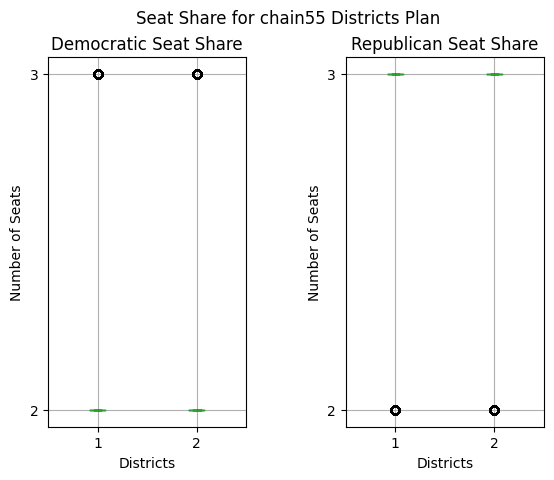

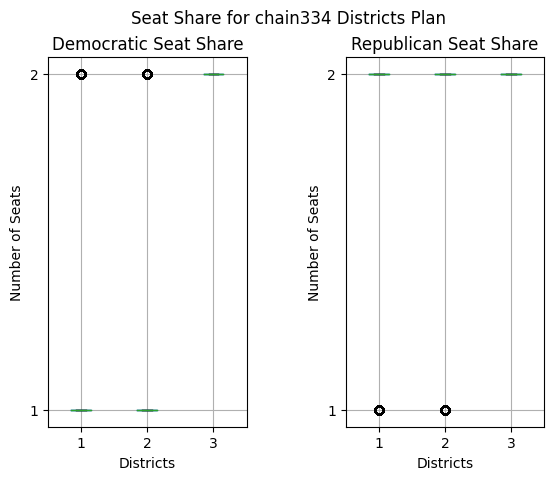

In [41]:
seat_data = {}
rep_total_count = [0] * (TOTAL_DISTRICTS + 1)
dem_total_count = [0] * (TOTAL_DISTRICTS + 1)

# Remove all candidates that have 0 votes
for link in master_dict:
    new_election = []
    for election in chain_dict[master_dict[link]]:
        new_election.append({})
        for district in election:
            new_election[-1][district] = {}
            for candidate in election[district]:
                if election[district][candidate] != 0:
                    new_election[-1][district][candidate] = election[district][candidate]
            

    for election in new_election:
        for district in election:
            # Remove half of the candidates
            election[district] = dict(list(election[district].items())[:int(len(election[district])/2)])

            # Sort districts by number of elements
            election[district] = dict(sorted(election[district].items(), key=lambda item: item[1], reverse=True))
    # Sort the districts by number of elements and re index them
    new_election = sorted(new_election, key=lambda x: len(x[len(x)]), reverse=True)
    for i in range(len(new_election)):
        new_election[i] = dict(sorted(new_election[i].items(), key=lambda x: len(x[len(x)-1]), reverse=False))
        new_election[i] = dict(enumerate(new_election[i].values(), start=1))
    chain_dict[master_dict[link]] = new_election
    
    dem_seatshare = []
    rep_seatshare = []
    for election in new_election:
        dem_dict = {}
        rep_dict = {}
        total_dem = 0
        total_rep = 0
        for district in election:
            # Get the number of repubicans and democrats
            num_dem = 0
            num_rep = 0
            for candidate in election[district]:
                if candidate[0] == "D":
                    num_dem += 1
                else:
                    num_rep += 1
            total_dem += num_dem
            total_rep += num_rep
            dem_dict[district] = num_dem
            rep_dict[district] = num_rep
        dem_total_count[total_dem] = dem_total_count[total_dem] + 1
        rep_total_count[total_rep] = rep_total_count[total_rep] + 1
        dem_seatshare.append(dem_dict)
        rep_seatshare.append(rep_dict)

    df_dem = pd.DataFrame(dem_seatshare)
    df_rep = pd.DataFrame(rep_seatshare)

    # Group both boxplots together
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Make y axis from 0 to 4 for both plots
   
    fig.suptitle("Seat Share for " + link + " Districts Plan")
    df_dem.boxplot(ax=ax1)
    ax1.set_title("Democratic Seat Share")
    ax1.set_xlabel("Districts")
    ax1.set_ylabel("Number of Seats")
    df_rep.boxplot(ax=ax2)
    ax2.set_title("Republican Seat Share")
    ax2.set_xlabel("Districts")
    ax2.set_ylabel("Number of Seats")
    # Add space between the two plots
    fig.subplots_adjust(wspace=0.5)

    seat_data[link] = [df_dem, df_rep]

    plt.show()



In [42]:
rep_total_count = {i: rep_total_count[i] for i in range(0, len(rep_total_count))}
rep_total_count

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 2455, 6: 7545, 7: 0, 8: 0, 9: 0, 10: 0}

In [43]:
dem_total_count = {i: dem_total_count[i] for i in range(0, len(dem_total_count))}
dem_total_count

{0: 0, 1: 0, 2: 0, 3: 0, 4: 7545, 5: 2455, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}

# Export

In [44]:
for reason in unique_plans:
    plan = unique_plans[reason]
    new_election = []
    new_election.append({})

    for district in plan[1]:
        new_election[-1][district] = {}
        for candidate in plan[1][district]:
            if plan[1][district][candidate] != 0:
                new_election[-1][district][candidate] = plan[1][district][candidate]

    for election in new_election:
        for district in election:
            # Remove half of the candidates
            election[district] = dict(list(election[district].items())[:int(len(election[district])/2)])

            # Sort districts by number of elements
            election[district] = dict(sorted(election[district].items(), key=lambda item: item[1], reverse=True))
    new_election = sorted(new_election, key=lambda x: len(x[len(x)]), reverse=True)
    for i in range(len(new_election)):
        new_election[i] = dict(sorted(new_election[i].items(), key=lambda x: len(x[len(x)-1]), reverse=False))
        new_election[i] = dict(enumerate(new_election[i].values(), start=1))
    chain_dict[master_dict[link]] = new_election
    
    dem_seatshare = []
    rep_seatshare = []
    for election in new_election:
        dem_dict = {}
        rep_dict = {}
        total_dem = 0
        total_rep = 0
        for district in election:
            num_dem = 0
            num_rep = 0
            for candidate in election[district]:
                if candidate[0] == "D":
                    num_dem += 1
                else:
                    num_rep += 1
            total_dem += num_dem
            total_rep += num_rep
            dem_dict[district] = num_dem
            rep_dict[district] = num_rep
        dem_total_count[total_dem] = dem_total_count[total_dem] + 1
        rep_total_count[total_rep] = rep_total_count[total_rep] + 1
        dem_seatshare.append(dem_dict)
        rep_seatshare.append(rep_dict)

    rep_dict = {"Reps": []}
    for rep in dem_seatshare:
        for district in rep:
            rep_arr = []
            for i in range(rep[district]):
                rep_arr.append("D")
            rep_dict["Reps"].append(rep_arr)

    for rep in rep_seatshare:
        for district in rep:
            rep_arr = rep_dict["Reps"][district-1]
            for i in range(rep[district]):
                rep_arr.append("R")

    # Convert each list to a string
    for i in range(len(rep_dict["Reps"])):
        rep_dict["Reps"][i] = "".join(rep_dict["Reps"][i])



    gdf = gpd.GeoDataFrame({"assignment": plan[0].assignment.to_series()}, geometry=plan[0].graph.geometry)
    district_shapes = gdf.dissolve(by='assignment', aggfunc='sum') # Combine the precincts to form districts
    district_shapes = district_shapes.to_crs(epsg="4326")
    tst = pd.DataFrame(rep_dict)
    tst.index = tst.index + 1

    district_shapes = district_shapes.join(tst)

    district_shapes["Dem"] = district_shapes["Reps"].str.count("D") / district_shapes["Reps"].str.len()
    district_shapes["Rep"] = district_shapes["Reps"].str.count("R") / district_shapes["Reps"].str.len()

    district_shapes.to_file(f"{EXPORT_PATH}/unique plans/{reason} MMD.geojson", driver='GeoJSON', encoding='utf-8')


In [45]:

import json

unique_plan_data = {}

for reason in unique_plans:
    plan = unique_plans[reason]
    blk = pd.Series(plan[0]["black"])
    asn = pd.Series(plan[0]["asian"])
    hsp = pd.Series(plan[0]["hisp"])
    wt = pd.Series(plan[0]["white"])
    tot = pd.Series(plan[0]["population"])
    minority_population = blk + asn + hsp
    minority_pop_percentage = minority_population / tot
    
    dem = pd.Series(plan[0]["CongressionalRace"].percents("Democratic"))
    rep = pd.Series(plan[0]["CongressionalRace"].percents("Republican"))
    
    safe_districts = dem[dem > SAFE_SEAT_THRESHOLD].count() + rep[rep > SAFE_SEAT_THRESHOLD].count()
    opportunit_reps = minority_population[minority_population > MINORITY_POP_THRESHOLD * tot].count()
    pp_scores = pd.Series(polsby_popper(unique_plans[reason][0]))
    
    unique_plan_data[reason] = {
        "blk_pop": blk.to_dict(),
        "asn_pop": asn.to_dict(),
        "hsp_pop": hsp.to_dict(),
        "wt_pop": wt.to_dict(),
        "tot_pop": tot.to_dict(),
        "minority_pop": minority_population.to_dict(),
        "dem_split": dem.to_dict(),
        "rep_split": rep.to_dict(),
        "safe_districts": int(safe_districts),
        "opportunity_reps": int(opportunit_reps),
        "polsby_popper_scores": pp_scores.to_dict()
    }    


In [46]:
data = {}
temp = {}

for chain in all_data:
    temp[chain] = {}

for chain in all_data:
    all_data[chain]["polsby_popper_scores"] = all_data[chain]["polsby_popper_scores"].mean().to_dict()
    all_data[chain]["rep_splits"] = all_data[chain]["rep_splits"].mean().to_dict()
    all_data[chain]["dem_splits"] = all_data[chain]["dem_splits"].mean().to_dict()
    all_data[chain]["black_pop"] = all_data[chain]["black_pop"].mean().to_dict()
    all_data[chain]["asian_pop"] = all_data[chain]["asian_pop"].mean().to_dict()
    all_data[chain]["hispanic_pop"] = all_data[chain]["hispanic_pop"].mean().to_dict()
    all_data[chain]["white_pop"] = all_data[chain]["white_pop"].mean().to_dict()
    all_data[chain]["total_pop"] = all_data[chain]["total_pop"].mean().to_dict()
    all_data[chain]["minority_pop"] = all_data[chain]["minority_pop"].mean().to_dict()
    all_data[chain]["opportunity_reps_count"] = float(all_data[chain]["opportunity_reps_count"].mean())
    all_data[chain]["equal_pop"] = all_data[chain]["equal_pop"].mean().to_dict()
    all_data[chain]["dem_seat_share_percentage"] = all_data[chain]["dem_seat_share_percentage"].mean()
    all_data[chain]["dem_vote_share_percentage"] = all_data[chain]["dem_vote_share_percentage"].mean()
    all_data[chain]["rep_seat_share_percentage"] = all_data[chain]["rep_seat_share_percentage"].mean()
    all_data[chain]["rep_vote_share_percentage"] = all_data[chain]["rep_vote_share_percentage"].mean()
    all_data[chain]["black_pop_box_data"] = all_data[chain]["black_pop_box_data"].to_dict()
    all_data[chain]["asian_pop_box_data"] = all_data[chain]["asian_pop_box_data"].to_dict()
    all_data[chain]["hispanic_pop_box_data"] = all_data[chain]["hispanic_pop_box_data"].to_dict()
    all_data[chain]["white_pop_box_data"] = all_data[chain]["white_pop_box_data"].to_dict()
    all_data[chain]["total_pop_box_data"] = all_data[chain]["total_pop_box_data"].to_dict()
    all_data[chain]["opportunity_reps"] = all_data[chain]["opportunity_reps"].sum(axis=1).to_dict()
    temp[chain]= {
        "opportunity_reps": all_data[chain]["opportunity_reps"],
    }

    for frame in seat_data:
        all_data[chain][frame + "_dem_seats"] = seat_data[frame][0].to_dict()
        all_data[chain][frame + "_rep_seats"] = seat_data[frame][1].to_dict()
all_data["unique_plans_data"] = unique_plan_data
all_data["bar_data"] = {
    "opportunity_reps": temp,
    "rep_total_count": rep_total_count,
    "dem_total_count": dem_total_count,
}
# all_data.pop("opportunity_reps")

data["all_data"] = all_data


In [47]:
import json 

with open('va_data.json', 'w') as outfile:
    json.dump(data, outfile)